In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt 

from mssfp.simulations import ssfp
from mssfp.phantoms import tissue_map, shepp_logan
from mssfp.recons import gs_recon

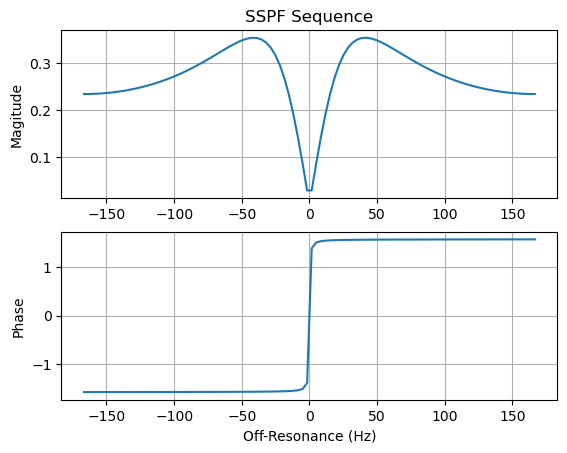

In [5]:
def ssfp_1d_example():
    T1, T2 = 1, .5
    TR, alpha = 3e-3, np.deg2rad(30)
    TE = TR / 2.0
    BetaMax = np.pi
    beta = np.linspace(-BetaMax, BetaMax, 100)
    f = beta / TR / (2 * np.pi)
    M = ssfp(T1, T2, TR, TE, alpha, f0=f)

    plt.subplot(211)
    plt.plot(f, np.absolute(M))
    plt.ylabel('Magitude')
    plt.title('SSPF Sequence')
    plt.grid(True)

    plt.subplot(212)
    plt.plot(f, np.angle(M))
    plt.xlabel('Off-Resonance (Hz)')
    plt.ylabel('Phase')
    plt.grid(True)
    plt.show()

ssfp_1d_example()

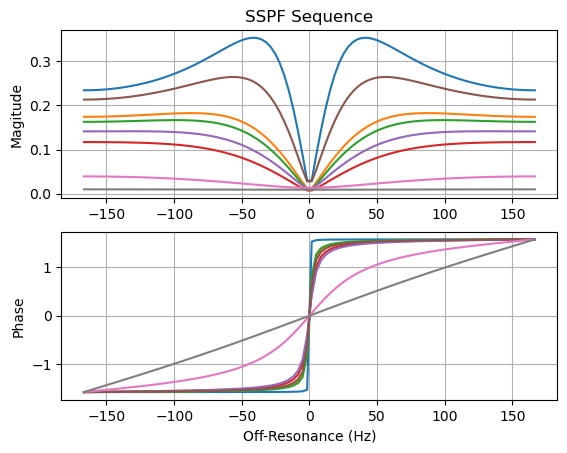

In [7]:
def ssfp_1d_example2():
    TR, alpha = 3e-3, np.deg2rad(30)
    TE = TR / 2.0
    BetaMax = np.pi
    beta = np.linspace(-BetaMax, BetaMax, 100)
    f = beta / TR / (2 * np.pi)

    keys = list(tissue_map.keys())
    M = []
    for key in keys:
        if key == 'none':
            continue
        T1 = tissue_map[key][0]
        T2 = tissue_map[key][1]
        M.append(ssfp(T1, T2, TR, TE, alpha, f0=f))
    M = np.squeeze(np.array(M))
    M = np.transpose(M, (1,0))

    plt.subplot(211)
    plt.plot(f, np.absolute(M))
    plt.ylabel('Magitude')
    plt.title('SSPF Sequence')
    plt.grid(True)

    plt.subplot(212)
    plt.plot(f, np.angle(M))
    plt.xlabel('Off-Resonance (Hz)')
    plt.ylabel('Phase')
    plt.grid(True)
    plt.show()
    
ssfp_1d_example2()

..\mssfp\simulations\ssfp.py:64: RuntimeWarning: divide by zero encountered in divide
  E1 = np.where(T1 > 0, np.exp(-TR / T1), 0)
..\mssfp\simulations\ssfp.py:64: RuntimeWarning: overflow encountered in exp
  E1 = np.where(T1 > 0, np.exp(-TR / T1), 0)
..\mssfp\simulations\ssfp.py:65: RuntimeWarning: divide by zero encountered in divide
  E2 = np.where(T2 > 0, np.exp(-TR / T2), 0)
..\mssfp\simulations\ssfp.py:65: RuntimeWarning: overflow encountered in exp
  E2 = np.where(T2 > 0, np.exp(-TR / T2), 0)
..\mssfp\simulations\ssfp.py:91: RuntimeWarning: divide by zero encountered in divide
  T2_decay = np.where(T2 > 0, np.exp(-TE / T2), 0)
..\mssfp\simulations\ssfp.py:91: RuntimeWarning: overflow encountered in exp
  T2_decay = np.where(T2 > 0, np.exp(-TE / T2), 0)


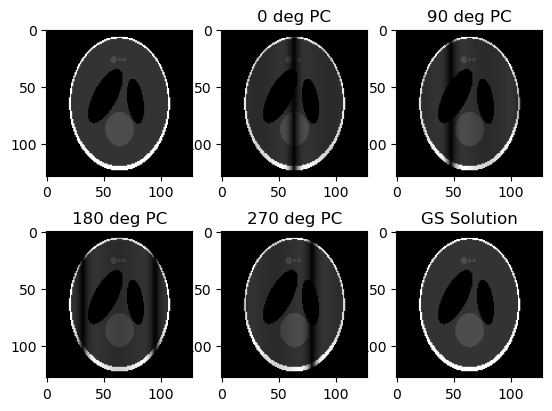

In [ ]:
def ssfp_2d_example():
    N = 128
    M0 = shepp_logan(N)

    T1, T2 = M0*2, M0/2
    TR, alpha = 3e-3, np.deg2rad(30)
    TE = TR / 2.0
    pcs = np.linspace(0, 2*np.pi, 4, endpoint=False)
    df, _ = np.meshgrid(
        np.linspace(-1/TR, 1/TR, N),
        np.linspace(-1/TR, 1/TR, N))

    data = ssfp(T1, T2, TR, TE, alpha, field_map=df, dphi=pcs, M0=M0)

    # Show Phantom 
    ny, nx = 3, 2
    plt.figure()
    plt.subplot(nx, ny, 1)
    plt.imshow(M0, cmap='gray')
    plt.title('Orginal')

    # Show the phase-cycled images
    for ii in range(4):
        plt.subplot(nx, ny, ii+2)
        plt.imshow(np.abs(data[..., ii]), cmap='gray')
        plt.title('%d deg PC' % (ii*90))

    # Show the recon
    recon = gs_recon(data, pc_axis=2)
    plt.subplot(nx, ny, 6)
    plt.imshow(np.abs(recon), cmap='gray')
    plt.title('GS Solution')
    plt.show()

    return data
    
data = ssfp_2d_example()

In [9]:
print(data.shape)

(128, 128, 4)


In [ ]:
def ssfp_PLANET_example():
    # Shepp-Logan
    N, nslices, npcs = 128, 2, 8 # 2 slices just to show we can
    M0, T1, T2 = shepp_logan(N)

    # Simulate bSSFP acquisition with linear off-resonance
    TR, alpha = 3e-3, np.deg2rad(15)
    pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
    df, _ = np.meshgrid(
        np.linspace(-1/TR, 1/TR, N),
        np.linspace(-1/TR, 1/TR, N))
    sig = np.empty((npcs,) + T1.shape, dtype='complex')
    for sl in range(nslices):
        sig[..., sl] = bssfp(T1[..., sl], T2[..., sl], TR, alpha, field_map=df, phase_cyc=pcs, M0=M0[..., sl])

    # Do T1, T2 mapping for each pixel
    mask = np.abs(M0) > 1e-8

    # Make it noisy
    sig += 1e-6*(np.random.normal(0, 1, sig.shape) + 1j*np.random.normal(0, 1, sig.shape))*mask

    # Do the thing
    Mmap, T1est, T2est = planet(sig, alpha, TR, mask=mask, pc_axis=0)

    # Look at a single slice
    sl = 0
    T1est = T1est[..., sl]
    T2est = T2est[..., sl]
    T1 = T1[..., sl]
    T2 = T2[..., sl]
    mask = mask[..., sl]

    nx, ny = 2, 3
    plt.subplot(nx, ny, 1)
    plt.imshow(T1*mask)
    plt.title('T1 Truth')
    plt.axis('off')

    plt.subplot(nx, ny, 2)
    plt.imshow(T1est)
    plt.title('T1 est')
    plt.axis('off')

    plt.subplot(nx, ny, 3)
    plt.imshow(T1*mask - T1est)
    plt.title('Residual')
    plt.axis('off')

    plt.subplot(nx, ny, 4)
    plt.imshow(T2)
    plt.title('T2 Truth')
    plt.axis('off')

    plt.subplot(nx, ny, 5)
    plt.imshow(T2est)
    plt.title('T2 est')
    plt.axis('off')

    plt.subplot(nx, ny, 6)
    plt.imshow(T2 - T2est)
    plt.axis('off')

    plt.show()
    
ssfp_PLANET_example()

NameError: name 'shepp_logan' is not defined